In [88]:
## Installations

!pip install qiskit[visualization]==0.43.3 --user
!pip install qiskit-aer --user

## Graph Generation

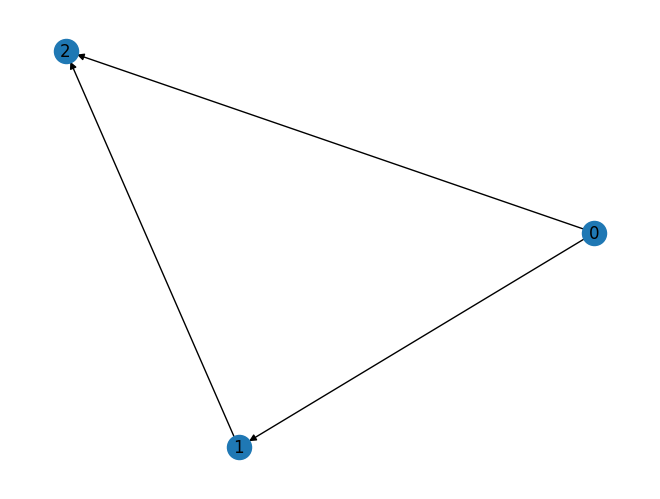

In [112]:
## Graph Generation

import random
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt

def random_directed_graph_with_prob(n, p):
    nodes = range(n)
    possible_edges = list(combinations(nodes, 2))
    #possible_edges = [(u,v) for u,v in possible_edges if u!=v]
    while True:
      adj_list = []
      outdegree = {node: 0 for node in nodes}
      for u, v in possible_edges:
          if random.random() < p:
              if outdegree[u] < 2:
                  adj_list.append((u, v))
                  outdegree[u] += 1

      G = nx.DiGraph()
      G.add_nodes_from(range(n))
      G.add_edges_from(adj_list)
      if nx.is_connected(G.to_undirected()):
        break
    return G

# Example usage:
n = 3  # Number of nodes
p = 1 # Probability of an edge existing

G = random_directed_graph_with_prob(n,p)

nx.draw(G, with_labels=True)
plt.show()

## Classical

In [113]:
## Classical

import networkx as nx
import random
from itertools import combinations

def is_dominating_set(G, node_set):
    for node in G.nodes:
        if node not in node_set and not any(neighbor in node_set for neighbor in G.successors(node)):
            return False
    return True

def find_all_dominating_sets(G):
    all_dominating_sets = []
    nodes = list(G.nodes)

    for size in range(1, len(nodes) + 1):
        for subset in combinations(nodes, size):
            if is_dominating_set(G, set(subset)):
                all_dominating_sets.append(set(subset))

    return all_dominating_sets

# Find all dominating sets
all_dominating_sets = find_all_dominating_sets(G)

# Find the smallest dominating set(s)
smallest_size = min(len(ds) for ds in all_dominating_sets)
smallest_sets = [ds for ds in all_dominating_sets if len(ds) == smallest_size]

print("Smallest Dominating Set(s):", smallest_sets)


Smallest Dominating Set(s): [{2}]


## Quantum

In [114]:
## Find tuples of v and all directed neighbors

nodes = list(G.nodes)

v_tuples = []

for v in nodes:
  v_tuple = set()
  v_tuple.add(v)

  for u in G.successors(v):
      v_tuple.add(u)
  v_tuples.append(v_tuple)

print(v_tuples)


[{0, 1, 2}, {1, 2}, {2}]


In [92]:
from itertools import chain, combinations

def all_nonempty_subsets(s):
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))

rzs = []
coefficients = []

for s in v_tuples:
  rzs.append(all_nonempty_subsets(s))
  coefficients.append(0.5 ** len(s))

#for r in rzs:
#  print(r)
#print(coefficients)

In [94]:
from collections import Counter

all_tuples = [tup for sublist in rzs for tup in sublist]
counts = Counter(all_tuples)
unique_tuples = [tup for tup, count in counts.items()]

print(unique_tuples)

[(0,), (1,), (2,), (0, 1), (0, 2), (1, 2), (0, 1, 2), (3,), (1, 3), (2, 3), (1, 2, 3), (4,), (2, 4), (3, 4), (2, 3, 4), (5,), (3, 5), (4, 5), (3, 4, 5), (6,), (4, 6), (5, 6), (4, 5, 6), (7,), (5, 7), (6, 7), (5, 6, 7)]


In [95]:
duplicates = [tup for tup, count in counts.items() if count > 1]

half_factors = [0] * len(unique_tuples)

for i, subset in zip(range(len(rzs)), rzs):
  for s in subset:
    index = unique_tuples.index(s)
    half_factors[index] += coefficients[i]

#print(half_factors)

In [96]:
tuple_dict = dict(zip(unique_tuples, half_factors))
#print(tuple_dict)

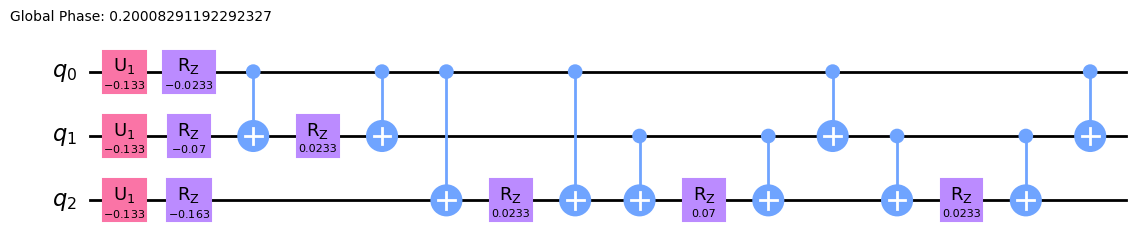

In [ ]:
# debugging
'''
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np

# Initialize Quantum Circuit
qc = QuantumCircuit(n)
alpha = np.random.uniform(0,1)

for i in range(n):
  qc.rz(-alpha,i)

lambda_factor = 0.7

for tup, coef in tuple_dict.items():
  qc.append(z_string(tup, 2 * lambda_factor * coef * alpha), list(range(n)))

qc.decompose().draw(output='mpl')
'''

In [115]:
from itertools import chain, combinations
from collections import Counter
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
import numpy as np


# function to add circuit based on a tuple
def z_string (subset, alpha):
  circ = QuantumCircuit(n)

  if len(subset) == 1:
    circ.rz(alpha,subset[0])
    return circ

  for i in range(len(subset) - 1):
    circ.cx(subset[i], subset[i+1])

  circ.rz(alpha, subset[-1])

  for i in range(len(subset) - 1, 0, -1):
    circ.cx(subset[i-1], subset[i])

  return circ

# find all subsets and the coefficients of each subset (subset is one v_tuple)
def all_nonempty_subsets(s):
    return list(chain.from_iterable(combinations(s, r) for r in range(1, len(s)+1)))

def Hc(G, qc, lambda_factor, alpha):
  # Find tuples of v and all directed neighbors
  nodes = list(G.nodes)
  v_tuples = []

  for v in nodes:
    v_tuple = set()
    v_tuple.add(v)

    for u in G.successors(v):
        v_tuple.add(u)
    v_tuples.append(v_tuple)

  rzs = []
  coefficients = []

  for s in v_tuples:
    rzs.append(all_nonempty_subsets(s))
    coefficients.append(0.5 ** len(s))

  # find any duplicates
  all_tuples = [tup for sublist in rzs for tup in sublist]
  counts = Counter(all_tuples)
  unique_tuples = [tup for tup, count in counts.items()]
  # find overall factor for each unique tuple
  duplicates = [tup for tup, count in counts.items() if count > 1]
  half_factors = [0] * len(unique_tuples)
  for i, subset in zip(range(len(rzs)), rzs):
    for s in subset:
      index = unique_tuples.index(s)
      half_factors[index] += coefficients[i]

  # create dict
  tuple_dict = dict(zip(unique_tuples, half_factors))

  # Quantum Circuit
  for i in range(n):
    qc.rz(alpha,i)

  for tup, coef in tuple_dict.items():
    qc.append(z_string(tup, -2 * lambda_factor * coef * alpha), list(range(n)))

  return qc

In [116]:
def Hm(G, qc, beta):
  for i in range(n):
    qc.rx(-2*beta, i)

# debugging
'''
beta = 0.2
qc = QuantumCircuit(n)
Hc(G, qc, lambda_factor, alpha)
Hm(G, qc, beta)
qc.decompose().draw(output='mpl')
'''

"\nbeta = 0.2\nqc = QuantumCircuit(n)\nHc(G, qc, lambda_factor, alpha)\nHm(G, qc, beta)\nqc.decompose().draw(output='mpl')\n"

In [117]:
def one_layer(G, qc, lambda_factor, alpha, beta):
  Hc(G, qc, lambda_factor, alpha)
  Hm(G, qc, beta)

# debugging
'''
qc = QuantumCircuit(n)
one_layer(G, qc, lambda_factor, alpha, beta)
qc.decompose().draw(output='mpl')
qc.measure_all()
'''

"\nqc = QuantumCircuit(n)\none_layer(G, qc, lambda_factor, alpha, beta)\nqc.decompose().draw(output='mpl')\nqc.measure_all()\n"

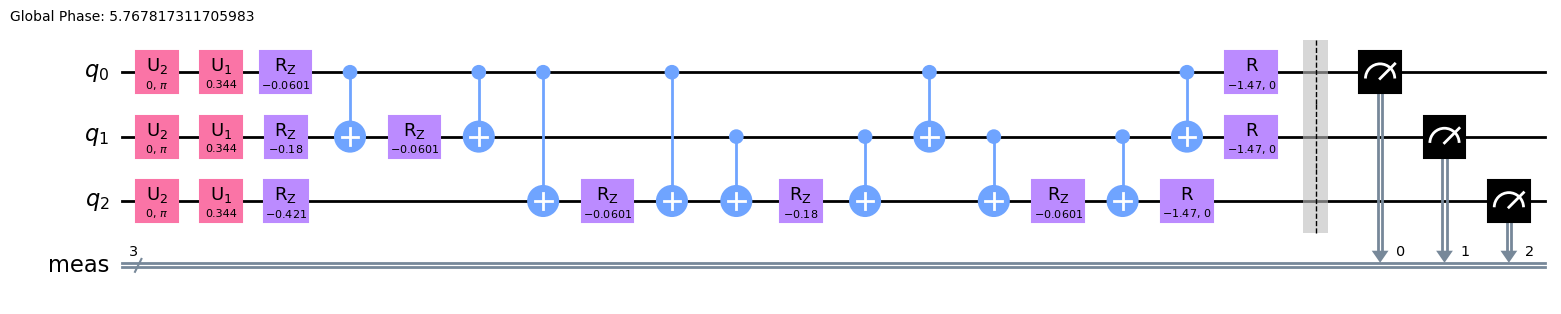

In [193]:
def circ_multi_layers(G, qc, lambda_factor, alphas, betas, num_layers):
  for qubit in range(n):
    qc.h(qubit)
  for i in range(num_layers):
    one_layer(G, qc, lambda_factor, alphas[i], betas[i])

#debugging
alphas = [np.random.uniform(0,1)]
betas = [np.random.uniform(0,1)]
lambda_factor = 0.7

qc = QuantumCircuit(n)
circ_multi_layers(G, qc, lambda_factor, alphas, betas, 1)
qc.measure_all()
qc.decompose().draw(output='mpl')

In [119]:
from qiskit import execute, Aer

job = execute(qc,Aer.get_backend('qasm_simulator'),shots=3000)

# we can get the result of the outcome as follows
counts = job.result().get_counts(qc)
#print(counts) # counts is a dictionary

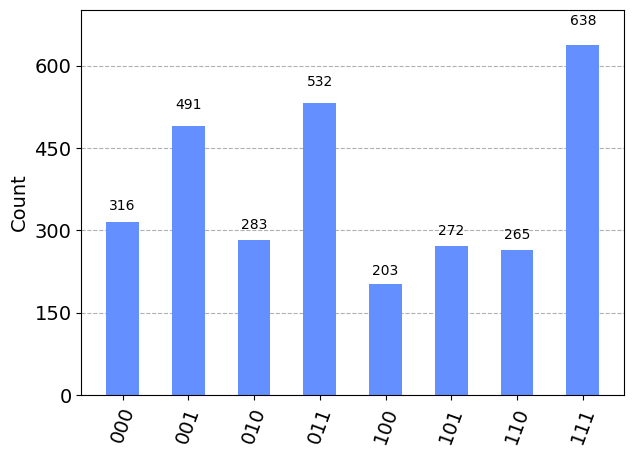

In [120]:
from qiskit.visualization import plot_histogram
plot_histogram(counts)

In [121]:
def phi(counts, shots):
  total = 0
  for k, v in counts.items():
    total += sum(int(bit) for bit in k) * (v/shots)
  return total

phi_value = phi(counts, 3000)
print(phi_value)

1.6763333333333335


In [122]:
# fix to take G instead of b and n (b found classically)

def min_fun(phi_value, G):
  n = len(G.nodes)
  all_dominating_sets = find_all_dominating_sets(G)
  # Find the smallest dominating set(s)
  b = min(len(ds) for ds in all_dominating_sets)
  print(b)
  return ((phi_value - n) / (b - n))

func = min_fun(phi(counts, 3000), G)

1


In [ ]:
#print(func)

In [123]:
def master_func(alpha_beta, *args):
  qc = QuantumCircuit(n)

  alphas = []
  betas = []

  for i in range(int(len(alpha_beta)/2)):
    alphas.append(alpha_beta[2*i])
    betas.append(alpha_beta[2*i+1])

  circ_multi_layers(G, qc, lambda_factor, alphas, betas, num_layers)

  qc.measure_all()

  job = execute(qc,Aer.get_backend('qasm_simulator'),shots=shots)
  # we can get the result of the outcome as follows
  counts = job.result().get_counts(qc)
  phi_value = phi(counts, shots)

  #func = min_fun(phi_value, G)

  return phi_value


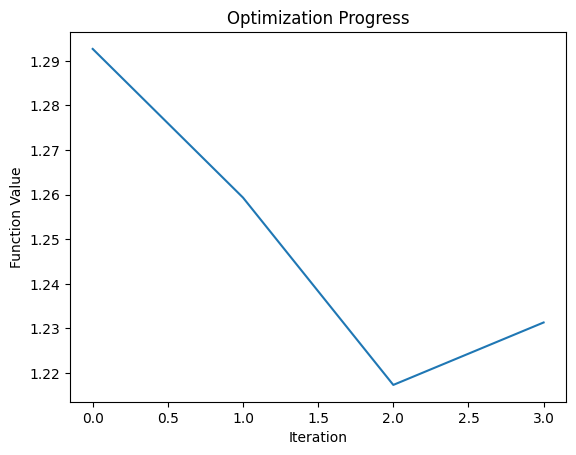

1
0.8885


In [139]:
import scipy.optimize
import matplotlib.pyplot as plt
from IPython.display import clear_output

funcs = []
lambda_factor = 2
shots = 3000
alpha_beta = [np.random.uniform(0,1), np.random.uniform(0,1)]
#alpha_beta = [np.random.uniform(0,1), np.random.uniform(0,1),
#              np.random.uniform(0,1), np.random.uniform(0,1),
#              np.random.uniform(0,1), np.random.uniform(0,1)
#              ]
#alpha_beta = [0,0]
num_layers = 1

args = []
args.append(G)
args.append(lambda_factor)
#args.append(alpha_beta)
args.append(num_layers)
args.append(shots)

'''
def my_callback(xk):
    iterations.append(xk)
    funcs.append(master_func(xk, *args))
    print(master_func(xk, *args))
    plt.plot(range(len(iterations)), master_func(xk, *args))

    plt.show()
'''

def my_callback(xk):
    iterations.append(xk)
    funcs.append((master_func(xk, *args)))
    clear_output(wait=True)
    plt.plot(range(len(funcs)), funcs)
    plt.xlabel('Iteration')
    plt.ylabel('Function Value')
    plt.title('Optimization Progress')
    plt.show()

iterations = []
y = scipy.optimize.minimize(master_func, alpha_beta, args, method='Powell', callback=my_callback)
func = min_fun(master_func(y.x, *args),G)
print(func)


In [140]:
y.x

array([-2.7544465 ,  2.15383252])

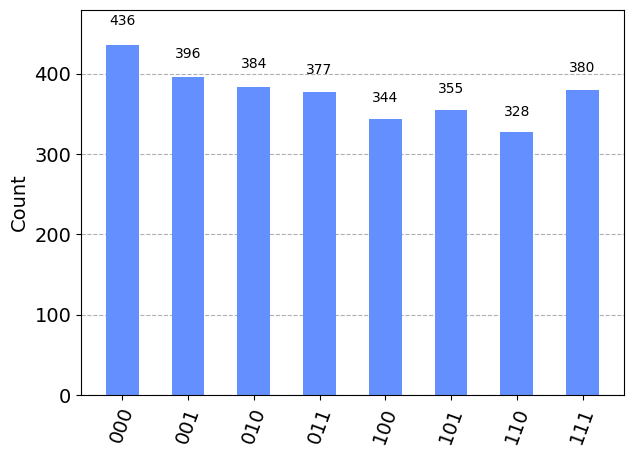

In [190]:
alphas = [alpha_beta[0]]
betas = [alpha_beta[1]]

qc = QuantumCircuit(n)
circ_multi_layers(G, qc, lambda_factor, alphas, betas, 1)
qc.measure_all()
qc.decompose().draw(output='mpl')

job = execute(qc, Aer.get_backend('qasm_simulator'), shots=3000)
counts = job.result().get_counts(qc)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

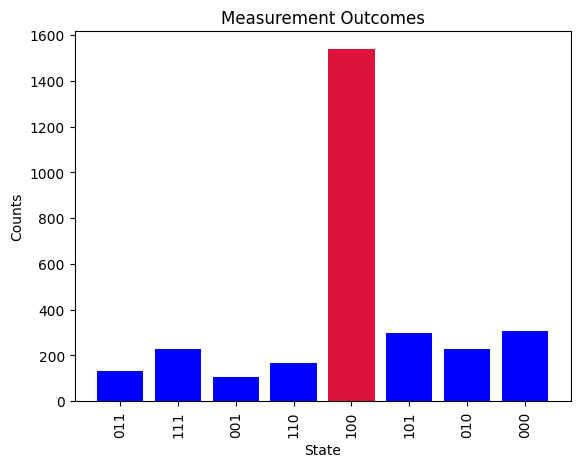

In [189]:
from qiskit import execute, Aer
import matplotlib.pyplot as plt

# Execute your quantum circuit
job = execute(qc, Aer.get_backend('qasm_simulator'), shots=3000)
counts = job.result().get_counts(qc)

# Find the key with the maximum count
max_key = max(counts, key=counts.get)

# Get all keys and find the index of the max key
keys = list(counts.keys())
index = sorted(keys).index(max_key)

# Create color list: red for max, blue for others
colors = ['blue' for _ in range(len(counts))]
colors[index] = 'crimson'

# Prepare values for the histogram
values = [counts[k] for k in keys]

# Plotting the histogram manually with colors
plt.bar(keys, values, color=colors)

# Labels and title
plt.xlabel('State')
plt.ylabel('Counts')
plt.title('Measurement Outcomes')
plt.xticks(rotation=90)  # Rotate the x-axis labels for readability
plt.show()
